This notebook ingests the CMP historical data and parses two separate traffix xml files then joins them.

The CMP historical data is good since it has geocoordinates.

In [90]:
import geopandas as gpd
%matplotlib inline
import pandas as pd

from json import dumps
from xmljson import badgerfish as bf
from xml.etree.ElementTree import Element, tostring
import xml.etree.ElementTree as ET
import os

In [91]:
CMP_Int = gpd.read_file('data/CMP_Int.shp')
CMP_Int = CMP_Int.to_crs({'init': 'epsg:4326'})

In [92]:
CMP_Int.columns

Index(['OBJECTID', 'STATUS', 'SCORE', 'SIDE', 'ARC_STREET', 'ID', 'CMP_SYSTEM',
       'CROSS_STRE', 'INTERSECTI', 'LOCATION', 'JURISDICTI', 'YR_1991',
       'YR_1992', 'YR_1993', 'YR_1994', 'YR_1996', 'YR_1997', 'YR_1998',
       'YR_2000', 'YR_2001', 'YR_2002', 'YR_2004', 'YR_2006', 'YR_2008',
       'YR_2010', 'LOS_RATING', 'LOS_2008', 'LOS_2006', 'LOS_2004', 'YR_2012',
       'ID_1', 'YR_2014', 'YR_2016', 'geometry'],
      dtype='object')

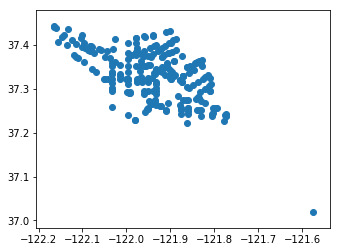

In [93]:
CMP_Int.plot()

In [94]:
CMP_Int.head()

,OBJECTID,STATUS,SCORE,SIDE,ARC_STREET,ID,CMP_SYSTEM,CROSS_STRE,INTERSECTI,LOCATION,...,YR_2010,LOS_RATING,LOS_2008,LOS_2006,LOS_2004,YR_2012,ID_1,YR_2014,YR_2016,geometry
0,54,T,100,None,Lawrence Expy & State Hwy 82,1214.0,Lawrence Exp.,El Camino Real (Rte 82),Lawrence Expy & State Hwy 82,Santa Clara,...,C,6,6,6,7,C,1214.0,C,C,POINT (-121.9965930082738 37.35223899061431)
1,55,T,100,None,Saratoga Sunnyvale Rd & State Hwy 9,1301.0,Big Basin Way (Hwy 9),Saratoga-Los Gatos Rd.,Saratoga Sunnyvale Rd & State Hwy 9,Saratoga,...,D+,8,8,9,7,D+,1301.0,D+,D+,POINT (-122.0319839991837 37.25921699567839)
2,56,T,100,None,Sunnyvale Saratoga Rd & W Fremont Ave,1401.0,Saratoga-Sunnyvale Rd.,Fremont Av.,Sunnyvale Saratoga Rd & W Fremont Ave,Sunnyvale,...,D,9,9,0,9,D,1401.0,D,D,POINT (-122.0324419959961 37.35204999538769)
3,57,M,100,None,Sunnyvale Saratoga Rd & E Remington Dr,1402.0,Saratoga-Sunnyvale Rd.,Remington Dr.,Sunnyvale Saratoga Rd & E Remington Dr,Sunnyvale,...,C-,7,9,0,9,D,1402.0,D,D,POINT (-122.0321700036354 37.35902599706698)
4,58,M,100,None,E Remington Dr & State Hwy 82,1404.0,El Camino Real (Rte. 82),Fair Oaks Av.,E Remington Dr & State Hwy 82,Sunnyvale,...,D,9,8,9,9,D,1404.0,D,D,POINT (-122.0250620091708 37.36169999372341)


In [95]:
tree = ET.parse('data/2016CMP80_PM.xml')
# tree = ET.parse('data/CMP_80_traffix_write_file_single_xml.in.xml')
root = tree.getroot()

In [98]:
def process_intersection(elements):
    return dumps(bf.data(elements))

In [99]:
def node_parser(node):
    node_dict = {}
    node_dict['ID'] = node.attrib.get('index')
    node_dict['name'] = node.find('name').text
    node_dict['volcount_date_year'] = node.find('volumedata').find('volcountdate').get('year')
    node_dict['volcount_date_month'] = node.find('volumedata').find('volcountdate').get('month')
    node_dict['volcount_date_day'] = node.find('volumedata').find('volcountdate').get('day')
    node_dict['voltimeperiod'] = node.find('volumedata').find('voltimeperiod').text
    node_dict['los'] = node.find('resultdata').find('los').text
    node_dict['averagedelay'] = node.find('resultdata').find('averagedelay').get('val')
    node_dict['averagecriticaldelay'] = node.find('resultdata').find('averagecriticaldelay').get('val')
    node_dict['optimalcycle'] = node.find('resultdata').find('optimalcycle').get('val')
    node_dict['criticalvoltocap'] = node.find('resultdata').find('criticalvoltocap').get('val')
    node_dict['criticalvoltocap'] = node.find('resultdata').find('criticalvoltocap').get('val')

    
    node_dict['nscontrol'] = node.find('geometrydata').find('control').get('nscontrol')
    node_dict['ewcontrol'] = node.find('geometrydata').find('control').get('ewcontrol')
    node_dict['cycletime'] = node.find('geometrydata').find('control').get('cycletime')
    node_dict['losstime'] = node.find('geometrydata').find('control').get('losstime')
    node_dict['y_r'] = process_intersection(node.find('geometrydata').find('yellowplusallred'))
    node_dict['lanes'] = process_intersection(node.find('geometrydata').find('lanes'))
    node_dict['min_green'] = process_intersection(node.find('geometrydata').find('mingreen'))
    node_dict['rights_nb'] = node.find('geometrydata').find('rtor').get('nb')
    node_dict['rights_sb'] = node.find('geometrydata').find('rtor').get('sb')
    node_dict['rights_eb'] = node.find('geometrydata').find('rtor').get('eb')
    node_dict['rights_wb'] = node.find('geometrydata').find('rtor').get('wb')
    
    node_dict['base_vol'] = process_intersection(node.find('resultdata').find('volumemodule').find('basevolume'))
    node_dict['user_adj_vol'] = process_intersection(node.find('resultdata').find('volumemodule').find('useradj'))
    node_dict['final_vol'] = process_intersection(node.find('resultdata').find('volumemodule').find('finalvolume'))
    
    node_dict['final_sat'] = process_intersection(node.find('resultdata').find('satmodule').find('finalsat'))

    node_dict['cap_vol_sat'] = process_intersection(node.find('resultdata').find('capacitymodule').find('voltosat'))
    node_dict['cap_vol_cap'] = process_intersection(node.find('resultdata').find('capacitymodule').find('voltocap'))
    node_dict['los_by_move'] = process_intersection(node.find('resultdata').find('losmodule').find('approachlosbymove'))
    node_dict['cap_delay_veh'] = process_intersection(node.find('resultdata').find('losmodule').find('delaycalc').find('finaldelay'))
    
    #     node.find('geometrydata').find('yellowplusallred').find('nb').items()
    return node_dict
#     print(node.find('volumedata').find('voltimeperiod').text)
# node_parser(node)

In [100]:
node_list = []
nodes = root.findall("node")
for node in nodes:
    node_list.append(node_parser(node))
#     break
df = pd.DataFrame(node_list)
df.head()

,ID,averagecriticaldelay,averagedelay,base_vol,cap_delay_veh,cap_vol_cap,cap_vol_sat,criticalvoltocap,cycletime,ewcontrol,...,rights_eb,rights_nb,rights_sb,rights_wb,user_adj_vol,volcount_date_day,volcount_date_month,volcount_date_year,voltimeperiod,y_r
0,101,28.51241,30.69518,"{""basevolume"": {""nb"": {""@left"": 190.0, ""@thru""...","{""finaldelay"": {""nb"": {""@left"": 54.7613, ""@thr...","{""voltocap"": {""nb"": {""@left"": 0.59839, ""@thru""...","{""voltosat"": {""nb"": {""@left"": 0.06032, ""@thru""...",0.57155,120,protect,...,Ovl,No,No,Ovl,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",6,12,2016,5:00 - 6:00 pm,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."
1,102,56.93715,47.77116,"{""basevolume"": {""nb"": {""@left"": 140.0, ""@thru""...","{""finaldelay"": {""nb"": {""@left"": 67.29492, ""@th...","{""voltocap"": {""nb"": {""@left"": 0.53322, ""@thru""...","{""voltosat"": {""nb"": {""@left"": 0.08, ""@thru"": 0...",0.60126,166,protect,...,Ovl,Ovl,Ovl,Ovl,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",1,12,2016,4:30 PM to 5:30 PM,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."
2,103,30.43571,25.11601,"{""basevolume"": {""nb"": {""@left"": 791.0, ""@thru""...","{""finaldelay"": {""nb"": {""@left"": 48.07382, ""@th...","{""voltocap"": {""nb"": {""@left"": 0.55739, ""@thru""...","{""voltosat"": {""nb"": {""@left"": 0.17381, ""@thru""...",0.66155,166,protect,...,Ovl,Ovl,No,No,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",1,12,2016,4:45 - 5:45 PM,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."
3,104,49.06350,52.22595,"{""basevolume"": {""nb"": {""@left"": 70.0, ""@thru"":...","{""finaldelay"": {""nb"": {""@left"": 138.48647, ""@t...","{""voltocap"": {""nb"": {""@left"": 0.87234, ""@thru""...","{""voltosat"": {""nb"": {""@left"": 0.04, ""@thru"": 0...",0.87234,166,protect,...,No,Ovl,Free,No,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",13,12,2016,4:45 - 5:45 PM,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."
4,105,52.74055,51.41155,"{""basevolume"": {""nb"": {""@left"": 444.0, ""@thru""...","{""finaldelay"": {""nb"": {""@left"": 64.13012, ""@th...","{""voltocap"": {""nb"": {""@left"": 0.6868, ""@thru"":...","{""voltosat"": {""nb"": {""@left"": 0.14095, ""@thru""...",0.71093,166,protect,...,Ovl,Ovl,Ovl,Ovl,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",2,1,2017,5:15 - 6:15 PM,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."


In [101]:
df.query("ID=='5214'")

,ID,averagecriticaldelay,averagedelay,base_vol,cap_delay_veh,cap_vol_cap,cap_vol_sat,criticalvoltocap,cycletime,ewcontrol,...,rights_eb,rights_nb,rights_sb,rights_wb,user_adj_vol,volcount_date_day,volcount_date_month,volcount_date_year,voltimeperiod,y_r
187,5214,24.66300,49.40820,"{""basevolume"": {""nb"": {""@left"": 0.0, ""@thru"": ...","{""finaldelay"": {""nb"": {""@left"": 0.0, ""@thru"": ...","{""voltocap"": {""nb"": {""@left"": 0.0, ""@thru"": 0....","{""voltosat"": {""nb"": {""@left"": 0.0, ""@thru"": 0....",1.15307,104,split,...,No,Ovl,No,Ovl,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",31,1,2017,4:30-5:30 PM,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."


In [102]:
t = df['cap_vol_cap'][191:192].values
print(t)

['{"voltocap": {"nb": {"@left": 0.20305, "@thru": 0.35528, "@rite": 0.34078}, "eb": {"@left": 0.49352, "@thru": 0.49352, "@rite": 0.22648}, "sb": {"@left": 0.75362, "@thru": 0.61875, "@rite": 0.01712}, "wb": {"@left": 0.56015, "@thru": 0.56015, "@rite": 0.16634}}}']


In [103]:
# [print(x.tag,x.attrib) for x in list(node.find('resultdata').find('capacitymodule').find('voltosat'))]

In [104]:
# [str(x.tag) + ' : ' + str(x.attrib) for x in list(node.find('resultdata').find('capacitymodule').find('voltosat'))]

In [105]:
tree = ET.parse('data/CMP_80_traffix_write_file_single_xml.in.xml')
root = tree.getroot()
node_list = []
nodes = root.findall("node")
# for node in nodes:
#     print(node)
#     node_list.append(node_parser(node))
    

In [106]:
#103 - <links ne="11708" e="105" se="11709" w="11704"/>
#104  <links nw="11708" e="11704" sw="11709" w="102"/>
def full_node_parser(node):
    node_dict = {}
    node_dict['ID'] = node.attrib.get('index')
    node_dict['name'] = node.find('name').text
    node_dict['xpos'] = node.find('position').get('xpos')
    node_dict['ypos'] = node.find('position').get('ypos')
#     node_dict['base_volume_data'] = [x.items() for x in list(node.find('volumedata').find('volume'))]
    if node.find('links') is not None:
        links = []
        for each in node.find('links').keys():
            links.append(node.find('links').get(each))
        node_dict['links'] = ', '.join(links)

#     node_dict['nlink'] = node.find('links').get('n')
#     node_dict['slink'] = node.find('links').get('s') 
#     node_dict['wlink'] = node.find('links').get('w')
    return node_dict

In [107]:
node_list = []
for node in nodes:
    node_list.append(full_node_parser(node))
#     break

link_df = pd.DataFrame(node_list)

In [135]:
link_df.head()

,ID,links,name,xpos,ypos
0,101,"105, 3071, 5430",Bascom/Campbell,2017,-1492
1,102,"7251, 104, 5429",Winchester/Hamilton,1877,-1422
2,103,"11708, 105, 11709, 11704",Hwy 17 NB/Hamilton,1975,-1424
3,104,"11708, 11704, 11709, 102",Hwy 17 SB/Hamilton,1937,-1424
4,105,"3070, 101, 103",Bascom/Hamilton,2017,-1424


In [109]:
# for node in nodes:
#     print(node.get('index'))
#     print(node.find('name').text)
# #     if node.find('links'):
# #         print('yay')
#     if node.find('links') is not None:
#         links = []
#         for each in node.find('links').keys():
            
#             print(each)
#             links.append(node.find('links').get(each))
#     print(links)

In [110]:
link_df['ID'][0]

'101'

In [111]:
link_df['ID'] = link_df['ID'].astype(int)
CMP_Int['ID'] = CMP_Int['ID'].astype(int)
df['ID'] = df['ID'].astype(int)

In [112]:
df.head()

,ID,averagecriticaldelay,averagedelay,base_vol,cap_delay_veh,cap_vol_cap,cap_vol_sat,criticalvoltocap,cycletime,ewcontrol,...,rights_eb,rights_nb,rights_sb,rights_wb,user_adj_vol,volcount_date_day,volcount_date_month,volcount_date_year,voltimeperiod,y_r
0,101,28.51241,30.69518,"{""basevolume"": {""nb"": {""@left"": 190.0, ""@thru""...","{""finaldelay"": {""nb"": {""@left"": 54.7613, ""@thr...","{""voltocap"": {""nb"": {""@left"": 0.59839, ""@thru""...","{""voltosat"": {""nb"": {""@left"": 0.06032, ""@thru""...",0.57155,120,protect,...,Ovl,No,No,Ovl,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",6,12,2016,5:00 - 6:00 pm,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."
1,102,56.93715,47.77116,"{""basevolume"": {""nb"": {""@left"": 140.0, ""@thru""...","{""finaldelay"": {""nb"": {""@left"": 67.29492, ""@th...","{""voltocap"": {""nb"": {""@left"": 0.53322, ""@thru""...","{""voltosat"": {""nb"": {""@left"": 0.08, ""@thru"": 0...",0.60126,166,protect,...,Ovl,Ovl,Ovl,Ovl,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",1,12,2016,4:30 PM to 5:30 PM,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."
2,103,30.43571,25.11601,"{""basevolume"": {""nb"": {""@left"": 791.0, ""@thru""...","{""finaldelay"": {""nb"": {""@left"": 48.07382, ""@th...","{""voltocap"": {""nb"": {""@left"": 0.55739, ""@thru""...","{""voltosat"": {""nb"": {""@left"": 0.17381, ""@thru""...",0.66155,166,protect,...,Ovl,Ovl,No,No,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",1,12,2016,4:45 - 5:45 PM,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."
3,104,49.06350,52.22595,"{""basevolume"": {""nb"": {""@left"": 70.0, ""@thru"":...","{""finaldelay"": {""nb"": {""@left"": 138.48647, ""@t...","{""voltocap"": {""nb"": {""@left"": 0.87234, ""@thru""...","{""voltosat"": {""nb"": {""@left"": 0.04, ""@thru"": 0...",0.87234,166,protect,...,No,Ovl,Free,No,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",13,12,2016,4:45 - 5:45 PM,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."
4,105,52.74055,51.41155,"{""basevolume"": {""nb"": {""@left"": 444.0, ""@thru""...","{""finaldelay"": {""nb"": {""@left"": 64.13012, ""@th...","{""voltocap"": {""nb"": {""@left"": 0.6868, ""@thru"":...","{""voltosat"": {""nb"": {""@left"": 0.14095, ""@thru""...",0.71093,166,protect,...,Ovl,Ovl,Ovl,Ovl,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",2,1,2017,5:15 - 6:15 PM,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."


In [113]:
link_df['ID'].nunique()

580

In [114]:
link_df.head()

,ID,links,name,xpos,ypos
0,101,"105, 3071, 5430",Bascom/Campbell,2017,-1492
1,102,"7251, 104, 5429",Winchester/Hamilton,1877,-1422
2,103,"11708, 105, 11709, 11704",Hwy 17 NB/Hamilton,1975,-1424
3,104,"11708, 11704, 11709, 102",Hwy 17 SB/Hamilton,1937,-1424
4,105,"3070, 101, 103",Bascom/Hamilton,2017,-1424


In [115]:
link_df.tail()

,ID,links,name,xpos,ypos
596,18818,18817,None,2474,711
597,18819,5625,None,1515,-977
598,18821,"18809, 18823, 3056",None,1954,-1169
599,18822,7226,None,-171,-437
600,18823,"18821, 7105, 12813, 3056",None,1955,-1202


In [116]:
CMP_Int['ID'].nunique()

255

In [117]:
df['ID'].nunique()

249

In [118]:
set(CMP_Int['ID'].unique()) - set(df['ID'].unique())

{3012, 3073, 3100, 3101, 5803, 5804}

In [119]:
#Missing Intersections
CMP_Int.loc[CMP_Int['ID'].isin(set(CMP_Int['ID'].unique()) - set(df['ID'].unique())),]

,OBJECTID,STATUS,SCORE,SIDE,ARC_STREET,ID,CMP_SYSTEM,CROSS_STRE,INTERSECTI,LOCATION,...,YR_2010,LOS_RATING,LOS_2008,LOS_2006,LOS_2004,YR_2012,ID_1,YR_2014,YR_2016,geometry
22,76,T,100,None,State Hwy 87 & Coleman Ave,3012,Hwy 87,Coleman Av.,State Hwy 87 & Coleman Ave,San Jose,...,NM,14,0,0,0,NM,3012.0,NM,NM,POINT (-121.9009090038399 37.34184400309833)
94,248,T,86,None,Montague Exp. & Capitol Av.,5803,Montague Exp.,Capitol Av.,Montague Exp. & Capitol Av.,Milpitas,...,D-,10,11,11,12,D-,5803.0,E+,NM,POINT (-121.8942910084896 37.41018099551391)
95,249,T,86,None,Montague Exp. & Milpitas Blvd.,5804,Montague Exp.,Milpitas Blvd.,Montague Exp. & Milpitas Blvd.,Milpitas,...,C-,7,8,9,8,D+,5804.0,C-,NM,POINT (-121.8867929927123 37.41252900308231)
139,137,M,100,L,6050 State Hwy 82,3073,Monterey Hwy. N,Bernal Rd.,6050 State Hwy 82,San Jose,...,C,6,6,6,6,C,3073.0,C,C,POINT (-121.7748347672189 37.2391614181243)
166,164,T,100,None,W Hedding St & State Hwy 87,3100,Guadalupe Parkway,Hedding St.,W Hedding St & State Hwy 87,San Jose,...,NM,14,0,0,0,NM,3100.0,NM,NM,POINT (-121.9093580129817 37.35036500525176)
167,165,T,100,None,W Taylor St & State Hwy 87,3101,Guadalupe Parkway,Taylor,W Taylor St & State Hwy 87,San Jose,...,NM,14,0,0,0,NM,3101.0,NM,NM,POINT (-121.9046459933454 37.34670599126902)


In [120]:
# CMP_Int

In [121]:
set(link_df['name'].unique()) - set(df['name'].unique())

{'87/COLEMAN',
 'BERNAL/MONTEREY (N)',
 'Bollinger Rd/Miller Ave',
 'De Anza Blvd/Rainbow Dr',
 'GUADALUPE/HEDDING',
 'GUADALUPE/TAYLOR',
 'Homestead Rd/Stelling Rd',
 'LAWRENCE EXPWY/SARATOGA ',
 'MONTAGUE EXPWY/CAPITOL AVE',
 'MONTAGUE EXPWY/MILPITAS BLVD',
 None,
 'Stelling Rd/McClellan Rd',
 'Stelling Rd/Rainbow Dr',
 'Wolfe Rd/Homestead Rd'}

In [122]:
set(df['ID'].unique()) - set(CMP_Int['ID'].unique())

set()

In [123]:
# set(link_df['ID'].unique()) - set(df['ID'].unique())

In [136]:
int_w_history = pd.merge(link_df, pd.merge(CMP_Int, df, how='left'), how='left')
int_w_history.head()

,ID,links,name,xpos,ypos,OBJECTID,STATUS,SCORE,SIDE,ARC_STREET,...,rights_eb,rights_nb,rights_sb,rights_wb,user_adj_vol,volcount_date_day,volcount_date_month,volcount_date_year,voltimeperiod,y_r
0,101,"105, 3071, 5430",Bascom/Campbell,2017,-1492,1.0,T,100.0,None,S. Bascom Ave & E. Campbell Ave,...,Ovl,No,No,Ovl,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",6,12,2016,5:00 - 6:00 pm,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."
1,102,"7251, 104, 5429",Winchester/Hamilton,1877,-1422,2.0,T,100.0,None,E. Hamilton Ave & Winchester Blvd,...,Ovl,Ovl,Ovl,Ovl,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",1,12,2016,4:30 PM to 5:30 PM,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."
2,103,"11708, 105, 11709, 11704",Hwy 17 NB/Hamilton,1975,-1424,3.0,T,100.0,None,E. Hamilton Ave & Creekside Way,...,Ovl,Ovl,No,No,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",1,12,2016,4:45 - 5:45 PM,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."
3,104,"11708, 11704, 11709, 102",Hwy 17 SB/Hamilton,1937,-1424,4.0,T,100.0,None,E. Hamilton Ave & Salmar Ave,...,No,Ovl,Free,No,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",13,12,2016,4:45 - 5:45 PM,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."
4,105,"3070, 101, 103",Bascom/Hamilton,2017,-1424,5.0,T,100.0,None,E. Hamilton Ave & S. Bascom Ave,...,Ovl,Ovl,Ovl,Ovl,"{""useradj"": {""nb"": {""@left"": 1.0, ""@thru"": 1.0...",2,1,2017,5:15 - 6:15 PM,"{""yellowplusallred"": {""nb"": {""@left"": 4.0, ""@t..."


In [127]:
del int_w_history['ID_1']

In [128]:
len(int_w_history)

601

In [129]:
sum(int_w_history['YR_2016'] == int_w_history['los'])

219

In [131]:
sum(int_w_history['geometry'].isnull())

353

In [132]:
int_w_history_clean = int_w_history.loc[~int_w_history['geometry'].isnull(),]
crs = {'init': 'epsg:4326'}
int_w_history_clean = gpd.GeoDataFrame(int_w_history_clean, crs=crs, geometry=int_w_history_clean['geometry'])


In [139]:
filename = 'output/int_w_history.geojson'
if os.path.exists(filename):
    os.remove(filename)
int_w_history_clean.to_file(filename, driver='GeoJSON')

NameError: name 'os' is not defined